# 04. PyTorch Custom Datasets Video Notebook

We've used some datasets with PyTorch before

But how do you get your own data into PyTorch?

One of the ways to do is via : custom datasets.

## Domain libraries
Dpeneding on what you're working on, vision, text, audio. recommendation, you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions

**Resources :**
* Book version of the course materials for 04 : https://www.learnpytorch.io/04_pytorch_custom_datasets/
* Ground truth version of notebook 04: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb

# 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn
from torch.fx.experimental.recording import shape_env_check_state_equal

print(torch.__version__)

2.5.1+cu124


In [2]:
!nvidia-smi

Wed Aug 13 20:57:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.153.02             Driver Version: 570.153.02     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   55C    P8              9W /   35W |      59MiB /   4096MiB |      6%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# setup agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

our datasets is a subset of the Food101 dataset

Food 101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing)

Our dataset starts with 3 classes of food and only 10% of the images (~75 training, 25 testing)

Why do this?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary

The whole point is to speed up how fast you can experiment

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("../Datasets/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it..
if image_path.is_dir():
    print(f"{image_path} exists, skipping download")
else:
    print(f"{image_path} does not exist")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza steak sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    requests = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza_steak_sushi.zip")
    f.write(requests.content)

# unzip pissa sushi steak data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza_steak_sushi.zip")
    zip_ref.extractall(image_path)

../Datasets/pizza_steak_sushi exists, skipping download
Unzipping pizza_steak_sushi.zip


## 2. Becoming one with the data (data preperation and data exploration)

In [5]:
import os
def walk_through_dir(dir_path):
    """
    walks through dir_path returning its contents
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in '../Datasets/pizza_steak_sushi'.
There are 3 directories and 0 images in '../Datasets/pizza_steak_sushi/test'.
There are 0 directories and 25 images in '../Datasets/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in '../Datasets/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in '../Datasets/pizza_steak_sushi/test/sushi'.
There are 3 directories and 0 images in '../Datasets/pizza_steak_sushi/train'.
There are 0 directories and 78 images in '../Datasets/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in '../Datasets/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in '../Datasets/pizza_steak_sushi/train/sushi'.


In [7]:
# setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('../Datasets/pizza_steak_sushi/train'),
 PosixPath('../Datasets/pizza_steak_sushi/test'))

## 2.1 Visualize an image

write code for
1. get all of the image paths
2. pick a random path using python's random.choice()
3. get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with python's PIL
5. we'll then show the image and print metadata

pizza
Random image path : ../Datasets/pizza_steak_sushi/train/pizza/2154394.jpg
Image class : pizza
Image height : 512
Image width : 512


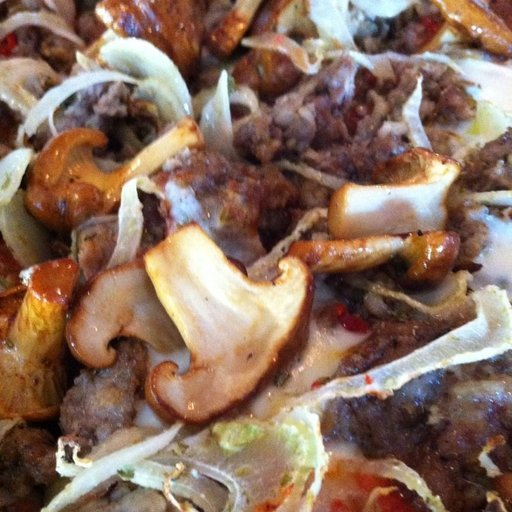

In [8]:
import random
from PIL import Image

# set seed
# random.seed(42)

# 1. get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. pick a random image path
random_image_path = random.choice(image_path_list)

# 3. get the image class from the path name (the image class is the name of the dir where the image is stored)
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print meta data
print(f"Random image path : {random_image_path}")
print(f"Image class : {image_class}")
print(f"Image height : {img.height}")
print(f"Image width : {img.width}")
img

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

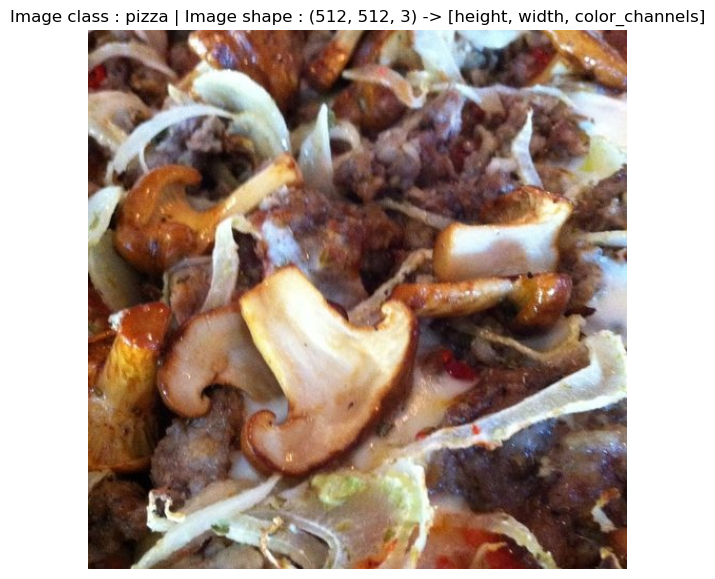

In [9]:
# use matplotlib
import matplotlib.pyplot as plt
import numpy as np

# turn the image into an array
img_as_array = np.asarray(img)

# plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class : {image_class} | Image shape : {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)


In [10]:
img_as_array

array([[[172, 150, 152],
        [165, 143, 145],
        [150, 129, 128],
        ...,
        [106,  56,  45],
        [ 97,  47,  36],
        [ 91,  41,  30]],

       [[155, 133, 135],
        [138, 117, 116],
        [111,  90,  89],
        ...,
        [100,  50,  39],
        [ 94,  44,  35],
        [ 91,  41,  30]],

       [[117,  97,  96],
        [ 98,  78,  77],
        [ 71,  50,  49],
        ...,
        [ 96,  46,  37],
        [ 92,  42,  35],
        [ 92,  42,  33]],

       ...,

       [[ 30,  11,   0],
        [ 34,  17,   1],
        [ 32,  14,   0],
        ...,
        [ 51,  25,   8],
        [ 59,  33,  18],
        [ 60,  34,  21]],

       [[ 34,  16,   2],
        [ 38,  20,   6],
        [ 31,  13,   1],
        ...,
        [ 48,  22,   5],
        [ 53,  27,  12],
        [ 59,  36,  22]],

       [[ 48,  30,  16],
        [ 49,  31,  17],
        [ 36,  20,   7],
        ...,
        [ 55,  29,  12],
        [ 45,  22,   6],
        [ 49,  26,  12]]

## 3. Transforming data

Before we can use our image data with PyTorch:
1. turn your target data into tensors (in our case, numerical representation of our images)
2. turn it into a `torch.utils.data.Dataset` and subsequently a `torch.util.data.DataLoader`, we'll call these `Dataset` and `DataLoader`

In [11]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to be used with a model/perform data augmentation - https://docs.pytorch.org/vision/stable/transforms.html

In [12]:
data_transform = transforms.Compose([
    # resize image
    transforms.Resize(size=(64, 64)),
    # flipping
    transforms.RandomHorizontalFlip(p=0.5),
    # turn to tensors
    transforms.ToTensor(),
])

In [13]:
data_transform(img).dtype

torch.float32

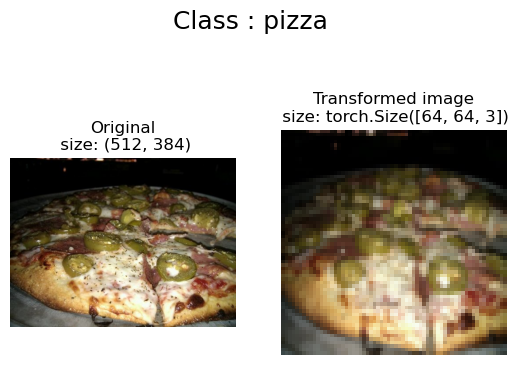

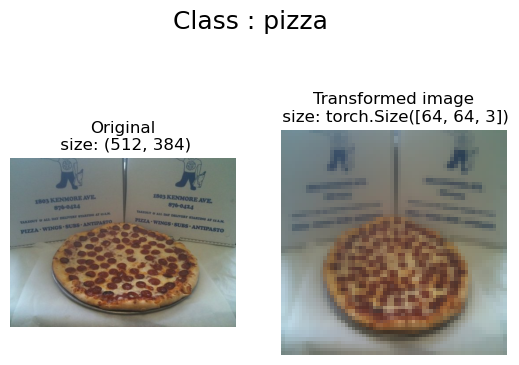

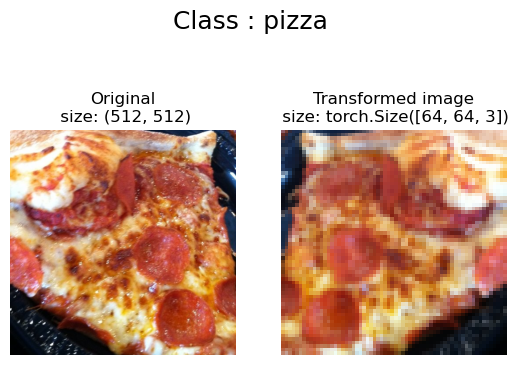

In [14]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=42):
    """
    Selects random images from a path of images and loads/tranforms them then plots the original vs transformed version
    :param image_paths:
    :param transform:
    :param n:
    :param seed:
    :return:
    """
    if seed :
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\n size: {f.size}")
            ax[0].axis(False)

            # transform and plot target image
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed image\n size: {transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class : {image_path.parent.stem}", fontsize=18)

plot_transformed_images(image_paths=image_path_list, transform=data_transform, n=3, seed=None)

## 4. Option 1: Loading image data using `ImageFolder`

We can load imgae classification using `torchvision.datasets.ImgaeFolder` - https://docs.pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html

In [15]:
# use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, transform=data_transform, target_transform=None)

test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: ../Datasets/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: ../Datasets/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [16]:
train_dir, test_dir

(PosixPath('../Datasets/pizza_steak_sushi/train'),
 PosixPath('../Datasets/pizza_steak_sushi/test'))

In [17]:
# see classes names
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [18]:
# see classes names but in index
index_class_names = train_data.class_to_idx
index_class_names

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [19]:
train_data.targets

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [20]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image shape : {img.shape}")
print(f"Image label : {label}")
print(f"Image datatype : {img.dtype}")
print(f"Image tensor : \n{img}")
print(f"Label datatyoe : {type(label)}")

Image shape : torch.Size([3, 64, 64])
Image label : 0
Image datatype : torch.float32
Image tensor : 
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.01

Original shape : torch.Size([3, 64, 64]) -> [color_channels, height, width]
Permuted shape : torch.Size([64, 64, 3]) -> [color_channels, height, width]


Text(0.5, 1.0, 'pizza')

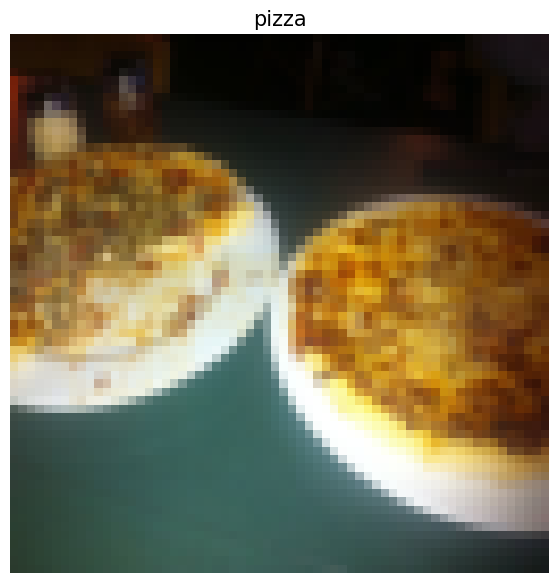

In [21]:
# Rearange the order of dimensions
img_permute = img.permute(1, 2, 0)

# print out different shapes
print(f"Original shape : {img.shape} -> [color_channels, height, width]")
print(f"Permuted shape : {img_permute.shape} -> [color_channels, height, width]")

# plot the images
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=15)

### Turn loaded images into `Dataloader`

A `Dataloader` is going to help us turn our `Dataset` into iterables and we can customize the `batch_size` so our model can see `batch_size` images at a time

In [22]:
# turn the train and test datasets into Dataloader format
train_daloader = DataLoader(train_data, batch_size=1, shuffle=True, num_workers=os.cpu_count())

test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False, num_workers=os.cpu_count())

train_daloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fde03f07f40>,
 <torch.utils.data.dataloader.DataLoader at 0x7fde040bcb20>)

In [23]:
len(train_daloader), len(test_dataloader)

(225, 75)

In [24]:
img, label = next(iter(train_daloader))

# batch size will now be 1, can change the batch size if you like

print(f"Image shape : {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape : {label.shape}")

Image shape : torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape : torch.Size([1])


## 5. Option 2: Loading Image Data with a custom `dataset`

1. want to be able to load images from file
2. want to able to get class names from the dataset
3. want to be able to get classes as dictionary from the dataset

Pros :
- Can create a `Dataset` out of almost everything
- Not limited to PyTorch pre-built `Dataset` functions

Cons :
- eventhough you could create `Dataset` out of almost anything, it doesn't mean it will work...
- using a custom `dataset` often results in us writing more code, which could be prone to errors or performance issues

All custom datasets in PyTorch, often subclass - https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.Dataset

In [25]:
import os
import pathlib
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import List, Tuple, Dict

In [26]:
# instance of torchvision.Datasets.ImageFolder()

train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 creating a helper function to get class names

we want a function to:
1. get the class names using `os.scandir()`to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure)
3. turn the class names into a dict and a list and return them

In [30]:
# setup path directory
target_directory = train_dir
print(f"Target directory : {target_directory}")

# get tge class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target directory : ../Datasets/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [31]:
list(os.scandir(target_directory))

[<DirEntry 'pizza'>, <DirEntry 'steak'>, <DirEntry 'sushi'>]

In [35]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """
    finds the classes folder name in a target directory"""
    # 1. get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Could not find any classes in {directory}... okease check file structure")

    # 3. Create a ditionary of index labels (computers prefer numbers rather than strings as labels)
    class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}
    return classes, class_to_idx


In [36]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})